# Importing Modules

In [4]:
import pandas as pd
import missingno as mno
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.impute import KNNImputer
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import re

In [ ]:
def compute_angle(p1, p2, p3):
    """
    Compute the angle formed by three points (p1, p2, p3) where p2 is the vertex.
    """
    v1 = np.array([p1[0] - p2[0], p1[1] - p2[1]])
    v2 = np.array([p3[0] - p2[0], p3[1] - p2[1]])
    dot_product = np.dot(v1, v2)
    magnitude_v1 = np.linalg.norm(v1)
    magnitude_v2 = np.linalg.norm(v2)
    cos_angle = dot_product / (magnitude_v1 * magnitude_v2)
    angle = np.degrees(np.arccos(np.clip(cos_angle, -1.0, 1.0)))
    return angle

def add_angles(df):
    def calculate_angle(row, p1_name, p2_name, p3_name):
        p1 = (row[f'{p1_name}_X'], row[f'{p1_name}_Y'])
        p2 = (row[f'{p2_name}_X'], row[f'{p2_name}_Y'])
        p3 = (row[f'{p3_name}_X'], row[f'{p3_name}_Y'])
        if all(coord != 0 for coord in p1 + p2 + p3):
            return compute_angle(p1, p2, p3)
        else:
            return -1

    # Shoulder Angle (e.g., Shoulder angles with spine)
    df['Shoulder_Angle'] = df.apply(lambda row: calculate_angle(row, 'Left Shoulder', 'Right Shoulder', 'Left Hip'), axis=1)
    
    # Torso Incline Angles (e.g., Hips relative to shoulders)
    df['Left_Torso_Incline_Angle'] = df.apply(lambda row: calculate_angle(row, 'Left Hip', 'Left Shoulder', 'Left Elbow'), axis=1)
    df['Right_Torso_Incline_Angle'] = df.apply(lambda row: calculate_angle(row, 'Right Hip', 'Right Shoulder', 'Right Elbow'), axis=1)
    
    # Elbow Angles (e.g., Shoulder-Elbow-Wrist)
    df['Left_Elbow_Angle'] = df.apply(lambda row: calculate_angle(row, 'Left Shoulder', 'Left Elbow', 'Left Wrist'), axis=1)
    df['Right_Elbow_Angle'] = df.apply(lambda row: calculate_angle(row, 'Right Shoulder', 'Right Elbow', 'Right Wrist'), axis=1)
    
    # Hip-Knee Angles (e.g., Hip-Knee-Ankle)
    df['Left_Hip_Knee_Angle'] = df.apply(lambda row: calculate_angle(row, 'Left Hip', 'Left Knee', 'Left Ankle'), axis=1)
    df['Right_Hip_Knee_Angle'] = df.apply(lambda row: calculate_angle(row, 'Right Hip', 'Right Knee', 'Right Ankle'), axis=1)
    
    # Knee-Ankle Angles (e.g., Knee-Ankle-Foot, if you have foot points)
    df['Left_Knee_Ankle_Angle'] = df.apply(lambda row: calculate_angle(row, 'Left Knee', 'Left Ankle', 'Left Hip'), axis=1)
    df['Right_Knee_Ankle_Angle'] = df.apply(lambda row: calculate_angle(row, 'Right Knee', 'Right Ankle', 'Right Hip'), axis=1)
    
    # Head to Shoulders Angle
    df['Head_to_Shoulders_Angle'] = df.apply(lambda row: calculate_angle(row, 'Nose', 'Left Shoulder', 'Right Shoulder'), axis=1)
    
    # Head to Hips Angle
    df['Head_to_Hips_Angle'] = df.apply(lambda row: calculate_angle(row, 'Nose', 'Left Hip', 'Right Hip'), axis=1)

    return df

# List of keypoint position columns
keypoint_columns = [
    'Nose_X', 'Nose_Y', 
    'Left Shoulder_X', 'Left Shoulder_Y', 'Right Shoulder_X', 'Right Shoulder_Y',
    'Left Elbow_X', 'Left Elbow_Y', 'Right Elbow_X', 'Right Elbow_Y',
    'Left Wrist_X', 'Left Wrist_Y', 'Right Wrist_X', 'Right Wrist_Y',
    'Left Hip_X', 'Left Hip_Y', 'Right Hip_X','Right Hip_Y',
    'Left Knee_X', 'Left Knee_Y', 'Right Knee_X', 'Right Knee_Y',
    'Left Ankle_X', 'Left Ankle_Y', 'Right Ankle_X', 'Right Ankle_Y'
]

# Function to calculate acceleration
def calculate_acceleration(df, columns):
    df = df.sort_values(by='File Name')  # Sort by frame number
    for col in columns:
        # Adding a temporary velocity column to help aid calculation of acceleration
        df[f'{col}_velocity'] = df.groupby('Folder Name')[col].diff()  # Calculate the rate of change (velocity)
        df[f'{col}_acceleration'] = df.groupby('Folder Name')[f'{col}_velocity'].diff()  # Calculate the rate of change of velocity (acceleration)
        
        # Removing columns which has velocity in their name
        df = df.drop(columns=[col for col in df.columns if 'velocity' in col])
    return df

def remove_outliers_iqr(df, column):
    # Calculate Q1 (25th percentile) and Q3 (75th percentile)
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1  # Calculate IQR

    # Check if IQR is very small to prevent excessive capping
    if IQR == 0:
        print(f"IQR is zero for column '{column}'. No outliers will be removed.")
        return df  # No outlier removal if IQR is 0

    # Define the lower and upper bounds
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Capping outliers
    df[column] = np.where(df[column] < lower_bound, lower_bound, df[column])
    df[column] = np.where(df[column] > upper_bound, upper_bound, df[column])

    return df

(30515, 37)
(216653, 37)


<Axes: >

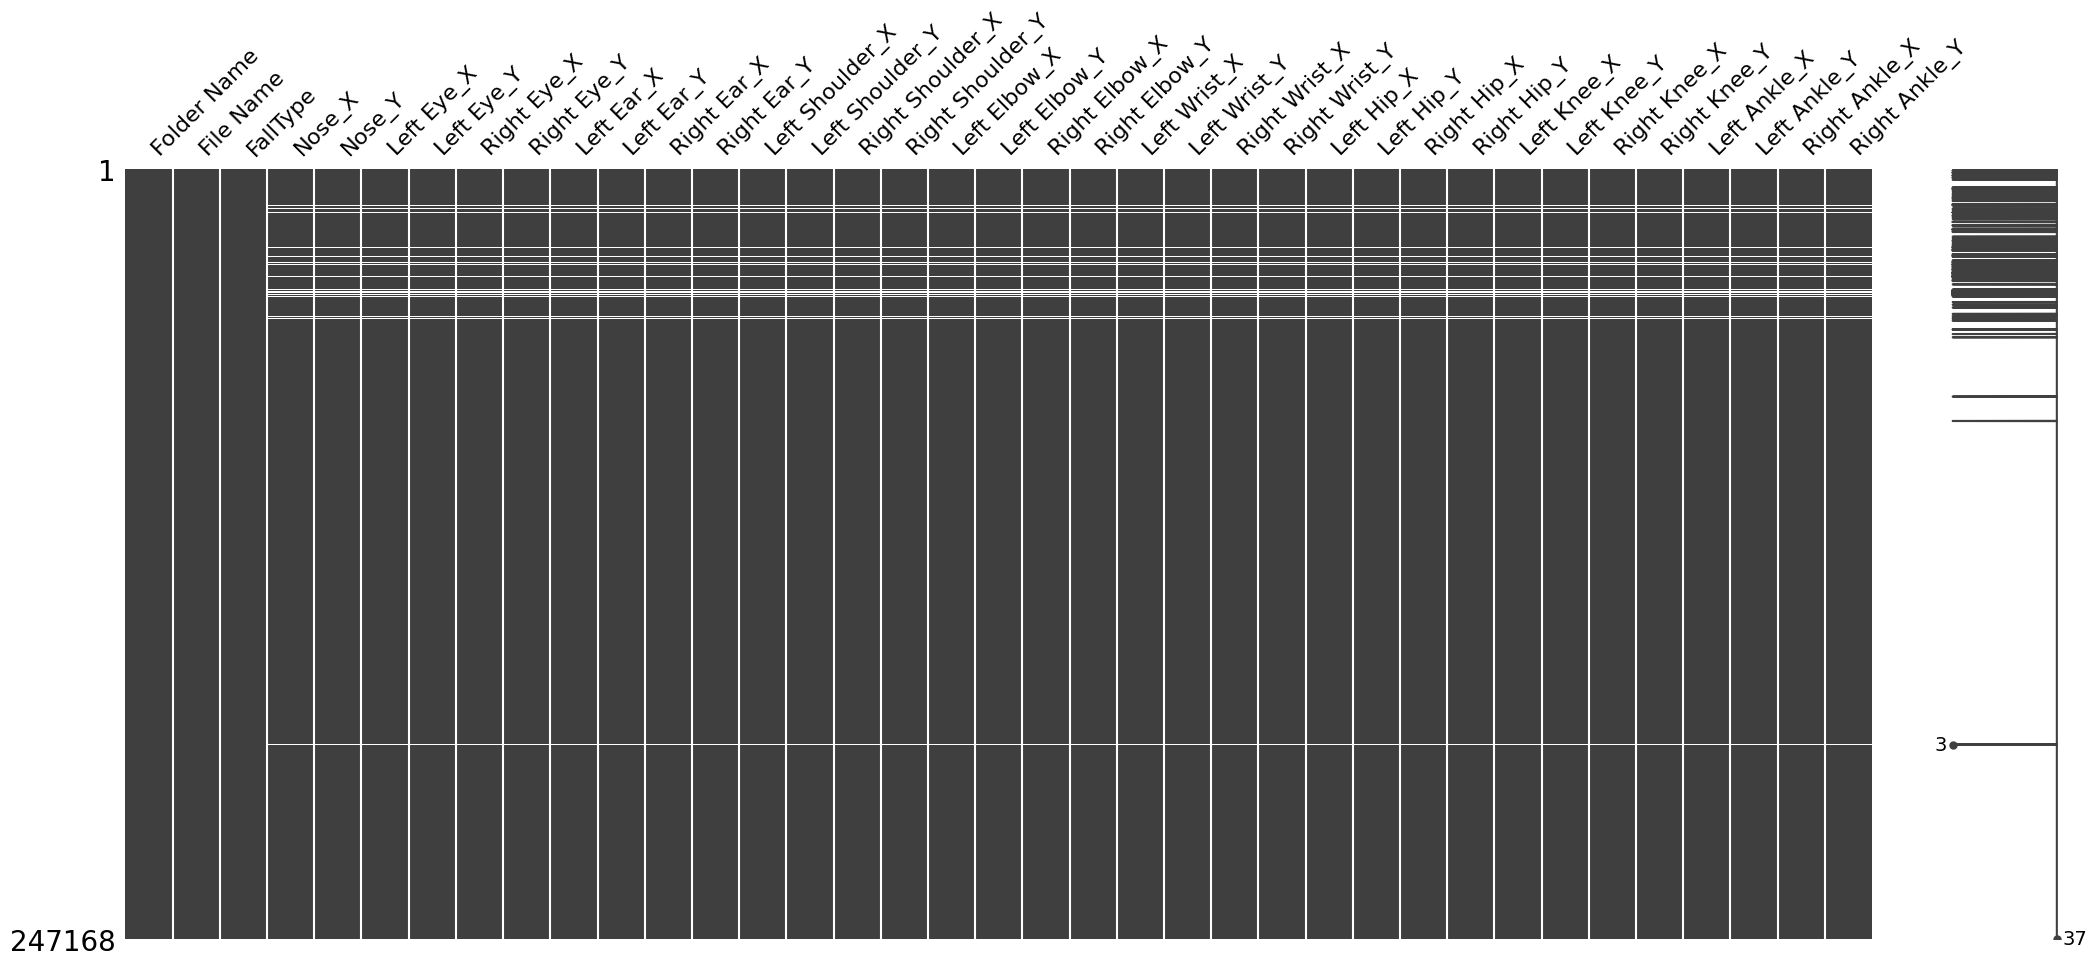

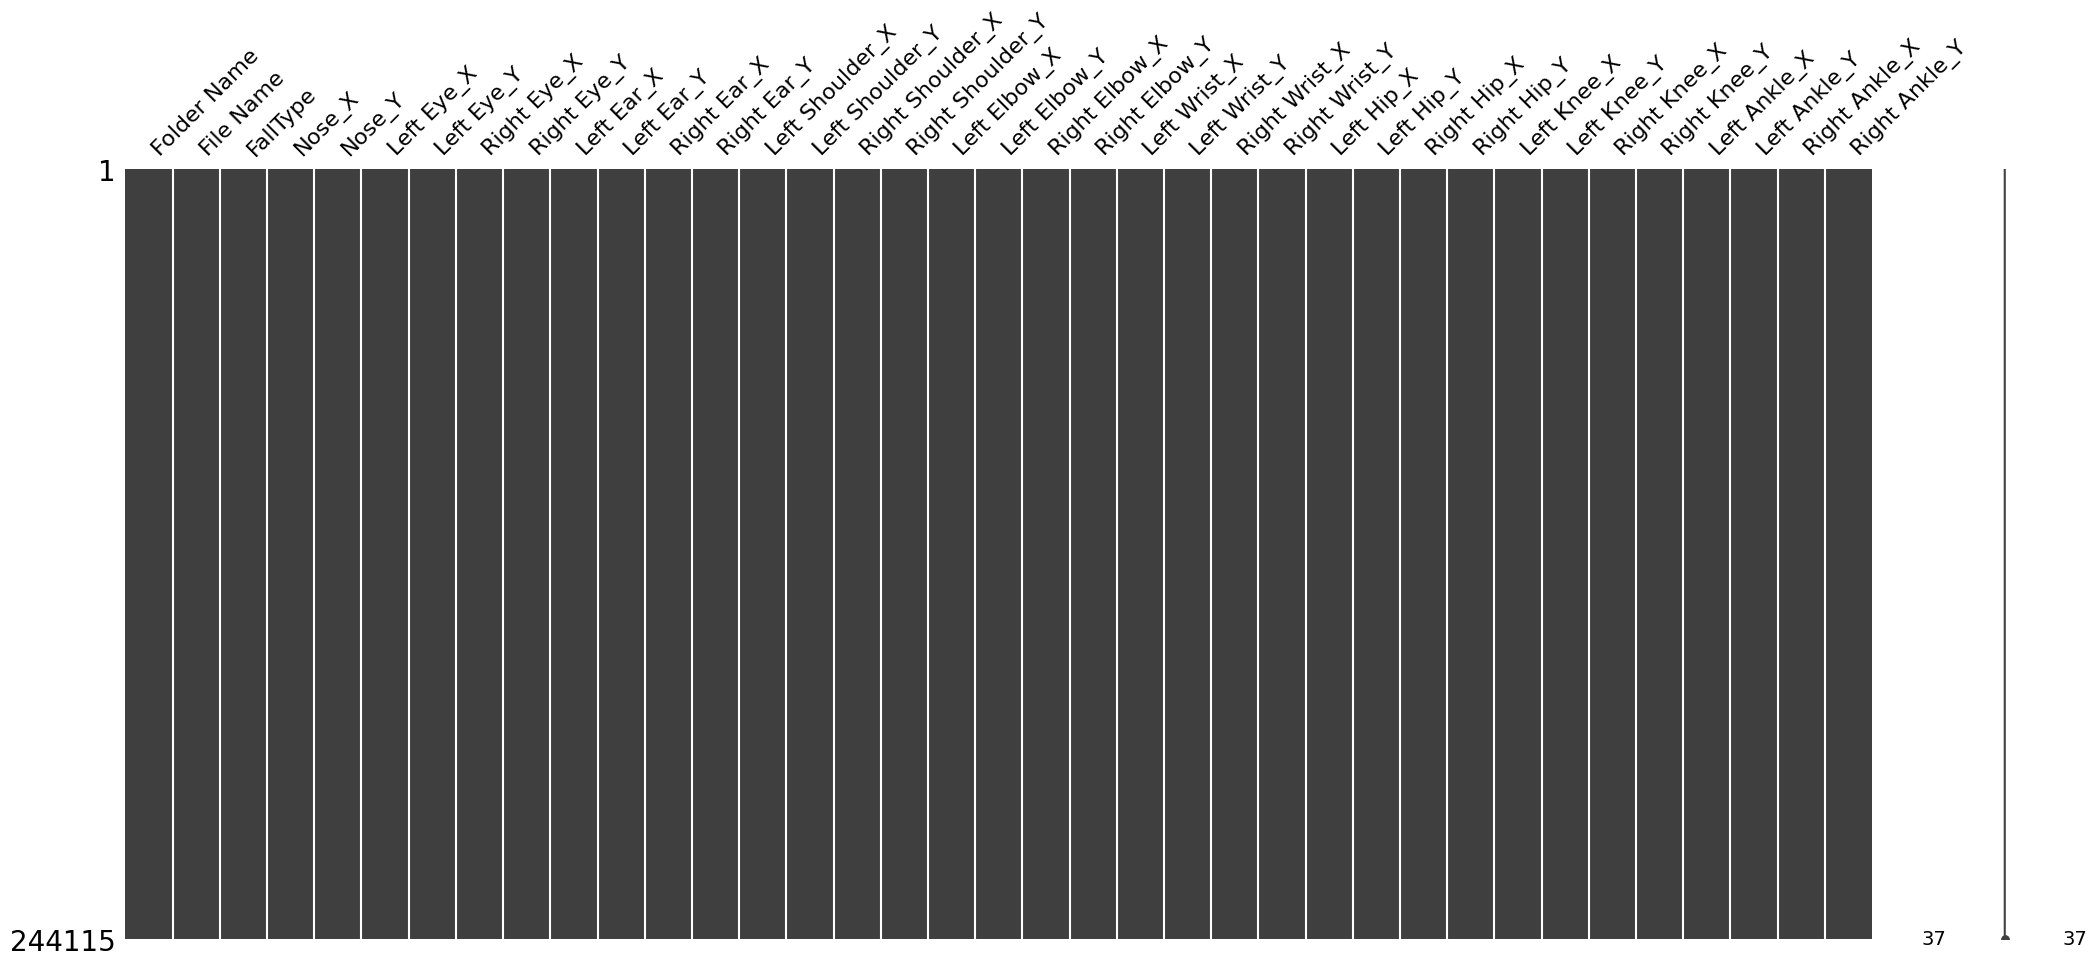

In [7]:
# Loading the datasets: Below is before processing is done.
# Should have the keypoints x and y values (normalized already)
df1 = pd.read_csv("csv/output_training.csv")
print(df1.shape)
df2= pd.read_csv("csv/output_testing.csv")
print(df2.shape)
combined_df = pd.concat([df1, df2], axis=0)
print(combined_df.shape)

mno.matrix(combined_df)
df_cleaned = combined_df.dropna()
print(df_cleaned.shape)
mno.matrix(df_cleaned)

df_cleaned['FallType'] = df_cleaned['FallType'].replace({'NoFall': 0, 'Fall': 1})

# Count the occurrences of each class
class_counts = df_cleaned['FallType'].value_counts()

# Print the class distribution
print("Class distribution:")
print(class_counts)

# Example usage
df_angles = add_angles(df_cleaned)
print(df_angles.shape)
print(df_angles.columns)

# Apply the function to each folder
df_acceleration = df_angles.groupby('Folder Name').apply(calculate_acceleration, keypoint_columns).reset_index(drop=True)

# Save the results to a new CSV file
# df_acceleration.to_csv('data_with_acceleration.csv', index=False)
print(df_acceleration.shape)
mno.matrix(df_acceleration)

# Step 1: Interpolation
df_acceleration.iloc[:, 3:] = df_acceleration.iloc[:, 3:].interpolate(method='linear')
# df_acceleration.to_csv("df_interpolate_acceleration.csv", index=False)

# Step 2: KNN Imputation
imputer = KNNImputer(n_neighbors=5)
df_acceleration.iloc[:, 3:] = imputer.fit_transform(df_acceleration.iloc[:, 3:])
# df_acceleration.to_csv("df_impute_acceleration.csv", index=False)

mno.matrix(df_acceleration)


# IQR Handling Outliers and Normalization

In [ ]:
# Columns for Min-Max normalization
min_max_columns = [
    'Head_Tilt_Angle', 'Shoulder_Angle', 'Left_Torso_Incline_Angle', 
    'Right_Torso_Incline_Angle', 'Left_Elbow_Angle', 'Right_Elbow_Angle', 
    'Left_Hip_Knee_Angle', 'Right_Hip_Knee_Angle', 'Left_Knee_Ankle_Angle', 
    'Right_Knee_Ankle_Angle', 'Leg_Spread_Angle', 'Head_to_Shoulders_Angle', 
    'Head_to_Hips_Angle'
]

# Columns for Z-Score normalization
z_score_columns = [
    'Nose_X_velocity', 'Nose_X_acceleration', 'Nose_Y_velocity', 
    'Nose_Y_acceleration', 'Left Eye_X_velocity', 'Left Eye_X_acceleration', 
    'Left Eye_Y_velocity', 'Left Eye_Y_acceleration', 'Right Eye_X_velocity', 
    'Right Eye_X_acceleration', 'Right Eye_Y_velocity', 'Right Eye_Y_acceleration', 
    'Left Ear_X_velocity', 'Left Ear_X_acceleration', 'Left Ear_Y_velocity', 
    'Left Ear_Y_acceleration', 'Right Ear_X_velocity', 'Right Ear_X_acceleration', 
    'Right Ear_Y_velocity', 'Right Ear_Y_acceleration', 'Left Shoulder_X_velocity', 
    'Left Shoulder_X_acceleration', 'Left Shoulder_Y_velocity', 
    'Left Shoulder_Y_acceleration', 'Right Shoulder_X_velocity', 
    'Right Shoulder_X_acceleration', 'Right Shoulder_Y_velocity', 
    'Right Shoulder_Y_acceleration', 'Left Elbow_X_velocity', 
    'Left Elbow_X_acceleration', 'Left Elbow_Y_velocity', 
    'Left Elbow_Y_acceleration', 'Right Elbow_X_velocity', 
    'Right Elbow_X_acceleration', 'Right Elbow_Y_velocity', 
    'Right Elbow_Y_acceleration', 'Left Wrist_X_velocity', 
    'Left Wrist_X_acceleration', 'Left Wrist_Y_velocity', 
    'Left Wrist_Y_acceleration', 'Right Wrist_X_velocity', 
    'Right Wrist_X_acceleration', 'Right Wrist_Y_velocity', 
    'Right Wrist_Y_acceleration', 'Left Hip_X_velocity', 
    'Left Hip_X_acceleration', 'Left Hip_Y_velocity', 
    'Left Hip_Y_acceleration', 'Right Hip_X_velocity', 
    'Right Hip_X_acceleration', 'Right Hip_Y_velocity', 
    'Right Hip_Y_acceleration', 'Left Knee_X_velocity', 
    'Left Knee_X_acceleration', 'Left Knee_Y_velocity', 
    'Left Knee_Y_acceleration', 'Right Knee_X_velocity', 
    'Right Knee_X_acceleration', 'Right Knee_Y_velocity', 
    'Right Knee_Y_acceleration', 'Left Ankle_X_velocity', 
    'Left Ankle_X_acceleration', 'Left Ankle_Y_velocity', 
    'Left Ankle_Y_acceleration', 'Right Ankle_X_velocity', 
    'Right Ankle_X_acceleration', 'Right Ankle_Y_velocity', 
    'Right Ankle_Y_acceleration'
]

In [ ]:
df = df_acceleration.copy()

plt.figure(figsize=(20, 6))
sns.boxplot(data=df[min_max_columns])  # Adjust with your columns of interest
plt.title('Boxplot to detect outliers')
plt.xticks(rotation=90)  # Rotate column names if necessary
plt.show()

# Apply the IQR method to each column in the list
for col in min_max_columns:
    df = remove_outliers_iqr(df, col)

print("Outliers removed or capped")

plt.figure(figsize=(20, 6))
sns.boxplot(data=df[min_max_columns])  # Adjust with your columns of interest
plt.title('Boxplot to detect outliers')
plt.xticks(rotation=90)  # Rotate column names if necessary
plt.show()

plt.figure(figsize=(20, 6))
sns.boxplot(data=df[z_score_columns])  # Adjust with your columns of interest
plt.title('Boxplot to detect outliers')
plt.xticks(rotation=90)  # Rotate column names if necessary
plt.show()

# Apply the IQR method to each column in the list
for col in z_score_columns:
    df = remove_outliers_iqr(df, col)

print("Outliers removed or capped")

plt.figure(figsize=(20, 6))
sns.boxplot(data=df[z_score_columns])  # Adjust with your columns of interest
plt.title('Boxplot to detect outliers')
plt.xticks(rotation=90)  # Rotate column names if necessary
plt.show()

In [ ]:
# Min-Max Normalization
min_max_scaler = MinMaxScaler()
df[min_max_columns] = min_max_scaler.fit_transform(df[min_max_columns])

# Z-Score Normalization
z_score_scaler = StandardScaler()
df[z_score_columns] = z_score_scaler.fit_transform(df[z_score_columns])

# Now df contains the normalized columns
print(df.head())

plt.figure(figsize=(20, 6))
sns.boxplot(data=df)  # Adjust with your columns of interest
plt.title('Boxplot to detect outliers')
plt.xticks(rotation=90)  # Rotate column names if necessary
plt.show()

df.to_csv("normalized_df.csv", index=False)

# Creating a balanced dataset from the entire dataset

In [ ]:
# Separate the majority and minority classes
df = pd.read_csv("Experiment_df_removedBMLV.csv")
majority_class = df[df['FallType'] == 0]  # Assuming 0 is the majority class
minority_class = df[df['FallType'] == 1]  # Assuming 1 is the minority class

# Determine the number of instances in the minority class
num_minority = len(minority_class)

# Randomly select the same number of instances from the majority class
majority_class_sampled = majority_class.sample(num_minority, random_state=42)

# Combine the sampled majority class with the minority class
balanced_df = pd.concat([majority_class_sampled, minority_class])

# Shuffle the balanced DataFrame
balanced_df = balanced_df.sample(frac=1, random_state=42).reset_index(drop=True)
print(balanced_df.shape)

# Count the occurrences of each class
class_counts = balanced_df['FallType'].value_counts()

# Print the class distribution
print("Class distribution:")
print(class_counts)

# Sorting of the dataset in the correct order, for temporal analysis

In [ ]:
# Load your dataset
df = pd.read_csv('Experiment_df_balanced_removedBMLV.csv')  # Replace with your dataset path

# Function to extract numeric part from the filename
def extract_numeric(filename):
    match = re.search(r'\d+', filename)
    return int(match.group()) if match else float('inf')  # Return a large number if no match

# Create a new column for sorting
df['Numeric File Name'] = df['File Name'].apply(extract_numeric)

# Sort the dataset by 'Folder Name' and then by the new 'Numeric File Name'
sorted_df = df.sort_values(by=['Folder Name', 'Numeric File Name'])

# Optionally, drop the helper column if not needed
sorted_df.drop(columns=['Numeric File Name'], inplace=True)

# Optionally, reset the index if needed
sorted_df.reset_index(drop=True, inplace=True)

# Display the sorted DataFrame
print(sorted_df.head)
sorted_df.to_csv("sorted_df.csv", index=False)